In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [2]:
use_cuda = torch.cuda.is_available()
use_cuda = False
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [3]:
imsize = 1024

loader = transforms.Compose([
    transforms.Scale(imsize),
    transforms.CenterCrop(imsize),
    transforms.ToTensor()
])

def image_loader(image_name): # this thing just makes it look like batch of size 1
    image = Image.open(image_name)
    image = Variable(loader(image))
    image = image.unsqueeze(0)
    return image

style_img = image_loader("abstract1.jpg").type(dtype)
content_img = image_loader("myface.jpg").type(dtype)

assert style_img.size() == content_img.size(), "well them images wrong"

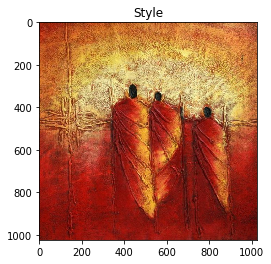

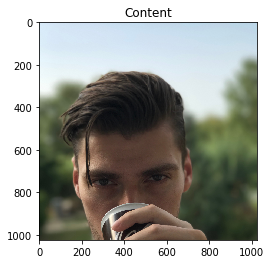

In [4]:
plt.ion()

def imshow(tensor, title="Image"):
    image = tensor.clone().cpu()
    image = image.view(3, imsize, imsize)
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    plt.title(title)
    plt.pause(0.001)

plt.figure()
imshow(style_img.data, title="Style")
plt.figure()
imshow(content_img.data, title="Content")

In [5]:
class ContentLoss(nn.Module):
    def __init__(self, target, weight):
        super(ContentLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight
        self.criterion = nn.MSELoss()
        
    def forward(self, input):
        self.loss = self.criterion(input * self.weight, self.target)
        self.output = input
        return self.output
    
    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph = retain_graph)
        return self.loss

In [6]:
class GramMatrix(nn.Module):
    def forward(self, input):
        a, b, c, d = input.size()
        features = input.view(a * b, c * d)
        G = torch.mm(features, features.t())
        
        return G.div(a * b * c * d)

In [7]:
class StyleLoss(nn.Module):
    def __init__(self, target, weight):
        super(StyleLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight
        self.gram = GramMatrix()
        self.criterion = nn.MSELoss()
        
    def forward(self, input):
        self.output = input.clone()
        self.G = self.gram(input)
        self.G.mul_(self.weight)
        self.loss = self.criterion(self.G, self.target)
        return self.output
    
    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph = retain_graph)
        return self.loss

In [8]:
cnn = models.vgg16(pretrained=True).features
if use_cuda:
    cnn = cnn.cuda()

In [9]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, style_img, content_img,
                              style_weight=1000, content_weight=1,
                              content_layers=content_layers_default,
                              style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)
    
    content_losses = []
    style_losses = []
    
    model = nn.Sequential()
    gram = GramMatrix()
    
    if use_cuda:
        model = model.cuda()
        gram = gram.cuda()
    
    i = 1
    for layer in list(cnn):
        if isinstance(layer, nn.Conv2d):
            name = "conv_" + str(i)
            model.add_module(name, layer)
            
            if name in content_layers:
                target = model(content_img).clone()
                content_loss = ContentLoss(target, content_weight)
                model.add_module("content_loss_"+str(i), content_loss)
                content_losses.append(content_loss)
            
            if name in style_layers:
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, style_weight)
                model.add_module("style_loss_"+str(i), style_loss)
                style_losses.append(style_loss)
                
            i+=1
            
        if isinstance(layer, nn.MaxPool2d):
            name = "pool_"+str(i)
            model.add_module(name, layer)
            
    return model, style_losses, content_losses

In [10]:
input_img = content_img.clone()

In [11]:
def get_input_param_optimizer(input_img):
    input_param = nn.Parameter(input_img.data)
    optimizer = optim.LBFGS([input_param])
    return input_param, optimizer

In [ ]:
def run_style_transfer(cnn, content_img, style_img, input_img, num_steps=300,
                  style_weight=1000, content_weight=1):
    
    model, style_losses, content_losses = get_style_model_and_losses(cnn, style_img, content_img, style_weight, content_weight)
    input_param, optimizer = get_input_param_optimizer(input_img)
    
    run = [0]
    while run[0] <= num_steps:
        def closure():
            input_param.data.clamp_(0,1)
            
            optimizer.zero_grad()
            model(input_param)
            style_score = 0
            content_score = 0
            
            for sl in style_losses:
                style_score += sl.backward()
            for cl in content_losses:
                content_score += cl.backward()
                
            run[0] += 1
            if(run[0] % 50 == 0):
                print(f'run {run}')
                print(f'style loss {style_score.data[0]} content loss {content_score.data[0]}')                
                print()
                
            return style_score + content_score
        
        optimizer.step(closure)
        
    input_param.data.clamp_(0, 1)
    
    return input_param.data

In [ ]:
output = run_style_transfer(cnn, content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()